<h1>RNN/LSTM Exercise</h1>


In this exercise we will be investigating RNN on their different forms and how they can be applied to solve the relation-extraction problem in natural language processing.
The relation extraction problem is defined as: given a triplet of a sentence and two entities in the sentence (e_1,e_2) , classify the relation between e_1-> e_2 given a finite set of possible relations. 

I.e  <br>
 *(e1) Flowers(/e1) are carried into the (e2)chapel(/e2).*
<br>
And possible relations ['Instrument-Agency', 'Message-Topic', 'Content-Container', 'Entity-Origin', 'Product-Producer', 'Entity-Destination', 'Cause-Effect', 'Component-Whole', 'Other', 'Member-Collection']

The best one would probably be ‘entity-destination’




*hint*: see https://github.com/tsterbak/keras_attention


In [1]:
import requests
import re
import numpy as np
import functools
import math
import pandas as pd
import numpy.random as n
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
from numpy import array
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM,Dense,SimpleRNN,Input,Embedding,Bidirectional,Dropout,SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop,Adam

###the file could be found in https://github.com/davidsbatista/Annotated-Semantic-Relationships-Datasets
with open("SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT") as f:
    train_file = f.readlines()

### 2.You are given a code using the keras package that transforms the data from sentences to numpy sequences and then trains an RNN model on it, run it for 20 epochs and report the results <br>

In [3]:
def prepare_dataset(raw):
    sentences, relations = [], []
    to_replace = [("\"", ""), ("\n", ""), ("<", " <"), (">", "> ")]
    last_was_sentence = False
    for line in raw:
        sl = line.split("\t")
        if last_was_sentence:
            relations.append(sl[0].split("(")[0].replace("\n", ""))
            last_was_sentence = False
        if sl[0].isdigit():
            sent = sl[1]
            for rp in to_replace:
                sent = sent.replace(rp[0], rp[1])
            sentences.append(sent)
            last_was_sentence = True
    print("Found {} sentences".format(len(sentences)))
    return sentences, relations

def _get_sequences(texts,tokenizer):
        seqs = tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=50,
                             value=0, padding='post', truncating='post')
    

In [4]:
sentences, relations = prepare_dataset(train_file)

Found 8000 sentences


In [5]:
sentences[0]

'The system as described above has its greatest application in an arrayed  <e1> configuration </e1>  of antenna  <e2> elements </e2> .'

In [6]:
relations[0]

'Component-Whole'

In [7]:
word_set=set()
for s in sentences:
    word_set|=set(s.split())

In [8]:
tokenizer=Tokenizer(num_words=len(word_set)+1, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token="UNK")
tokenizer.fit_on_texts(sentences)
label_dict={label:idx for idx,label in enumerate(set(relations))}

In [9]:
label_dict

{'Cause-Effect': 0,
 'Component-Whole': 1,
 'Entity-Origin': 2,
 'Instrument-Agency': 3,
 'Member-Collection': 4,
 'Entity-Destination': 5,
 'Other': 6,
 'Product-Producer': 7,
 'Content-Container': 8,
 'Message-Topic': 9}

In [10]:
X=_get_sequences(sentences,tokenizer)
Y=[label_dict[re] for re in relations]

In [11]:
X.shape

(8000, 50)

# <b>Questions</b>

### 1.What is the role of tf.keras.layers.Embedding here? Why is it needed?


##### source links:
https://www.tensorflow.org/tutorials/text/word_embeddings
<br>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

At first we will leave here some lines from documentation for better understanding of this function

tf.keras.layers.Embedding turns positive integers (indexes) into dense vectors of fixed size.
<br>
#### Arguments**

**input_dim:** Integer. Size of the vocabulary, i.e. maximum integer index + 1.<br>
**output_dim:** Integer. Dimension of the dense embedding.<br>
**embeddings_initializer:** Initializer for the embeddings matrix (see keras.initializers).<br>
**embeddings_regularizer:** Regularizer function applied to the embeddings matrix (see keras.regularizers).<br>
**embeddings_constraint:** Constraint function applied to the embeddings matrix (see keras.constraints).<br>
**mask_zero:** Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).<br>
**input_length:** Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).<br>
**Input shape**

2D tensor with shape: (batch_size, input_length).

**Output shape**

3D tensor with shape: (batch_size, input_length, output_dim).

##### And here the principe of work and the role of tf.keras.layers.Embedding
 Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter we can experiment with to see what works well for our problem, much in the same way we would experiment with the number of neurons in a Dense layer.

the model will take as input an integer matrix of size (batch,
input_length).
the largest integer (i.e. word index) in the input should be no larger vocabulary size.


In [12]:
def get_model():
    d = 0.5
    rd = 0.5
    rnn_units = 128
    input_text = Input((50,))
    text_embedding = Embedding(input_dim=len(word_set) + 2, 
                               output_dim=128,
                               input_length=50, 
                               mask_zero=True)(input_text)
    
    bilstm = SimpleRNN(units=rnn_units, 
                       return_sequences=False,
                       dropout=d,
                       recurrent_dropout=rd)(text_embedding)
    
    out = Dense(units=10, 
                activation="softmax")(bilstm)
    
    model = Model(input_text, out)
    return model

In [13]:
model=get_model()
model.compile(optimizer=RMSprop(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
tr_sent, te_sent, tr_rel, te_rel = train_test_split(X,
                                                    np.array(Y), 
                                                    test_size=0.1)


In [15]:
history = model.fit(x=tr_sent, 
                    y=tr_rel, 
                    validation_data=(te_sent,te_rel),
                    batch_size=10, 
                    epochs=20);

Epoch 1/20
720/720 [==============================] - 44s 61ms/step - loss: 2.4250 - accuracy: 0.1147 - val_loss: 2.4095 - val_accuracy: 0.1050
Epoch 2/20
720/720 [==============================] - 45s 63ms/step - loss: 2.3025 - accuracy: 0.1540 - val_loss: 2.3080 - val_accuracy: 0.1475
Epoch 3/20
720/720 [==============================] - 45s 62ms/step - loss: 2.2680 - accuracy: 0.1629 - val_loss: 2.2762 - val_accuracy: 0.1575
Epoch 4/20
720/720 [==============================] - 43s 60ms/step - loss: 2.2566 - accuracy: 0.1671 - val_loss: 2.2881 - val_accuracy: 0.1575
Epoch 5/20
720/720 [==============================] - 49s 68ms/step - loss: 2.2427 - accuracy: 0.1749 - val_loss: 2.2564 - val_accuracy: 0.1813
Epoch 6/20
720/720 [==============================] - 49s 68ms/step - loss: 2.2379 - accuracy: 0.1742 - val_loss: 2.2593 - val_accuracy: 0.1762
Epoch 7/20
720/720 [==============================] - 49s 68ms/step - loss: 2.2259 - accuracy: 0.1836 - val_loss: 2.2658 - val_accuracy:

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 128)           3416960   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 3,451,146
Trainable params: 3,451,146
Non-trainable params: 0
_________________________________________________________________


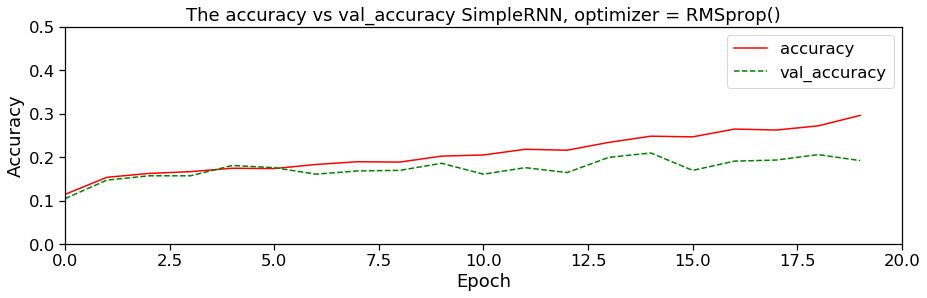

In [17]:
#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['accuracy'],'r', label='accuracy')
plt.plot(history.history['val_accuracy'],'g--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.5])
plt.xlim([0, 20])
plt.title('The accuracy vs val_accuracy SimpleRNN, optimizer = RMSprop()')
plt.legend(loc='best');

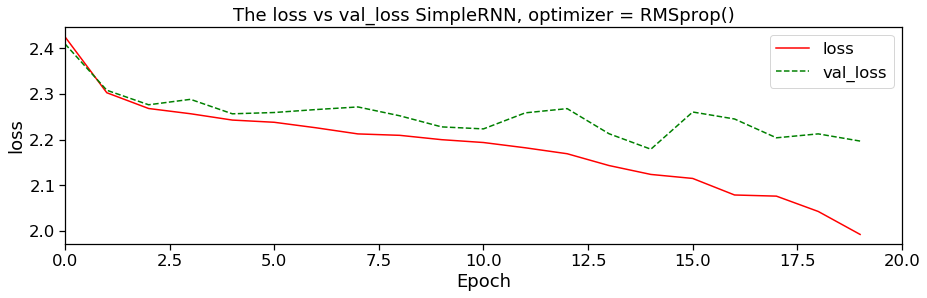

In [18]:
#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'],'r', label='loss')
plt.plot(history.history['val_loss'],'g--', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.xlim([0, 20])
plt.title('The loss vs val_loss SimpleRNN, optimizer = RMSprop()')
plt.legend(loc='best');

The accuracy is very low: about 0.2964 on the 20th epoch
<br>But we see, that val_accuracy is much lower: 0.1925 in the same point (the model may be overfitted.) 

Though we see the difference in loss: 1.9927 val_loss: 2.1968 . on the plot, it's visible  the training loss is dramatically falling, while the validation loss is oscillating.
It seems like severe overfitting!!


### 3.Switch to using Adam optimizer<br>


In [19]:
model1 = get_model()

model1.compile(loss='sparse_categorical_crossentropy', 
            optimizer = Adam(),
            metrics=["accuracy"])

In [20]:
tr_sent1, te_sent1, tr_rel1, te_rel1 = train_test_split(X,
                                                        np.array(Y),
                                                        test_size=0.1)

In [21]:
history1 = model1.fit(x=tr_sent1, 
                     y=tr_rel1, 
                     validation_data=(te_sent1,te_rel1),
                     batch_size=10,
                     epochs=20);

Epoch 1/20
720/720 [==============================] - 75s 104ms/step - loss: 2.4221 - accuracy: 0.1185 - val_loss: 2.2540 - val_accuracy: 0.1663
Epoch 2/20
720/720 [==============================] - 88s 122ms/step - loss: 2.3076 - accuracy: 0.1492 - val_loss: 2.2519 - val_accuracy: 0.1863
Epoch 3/20
720/720 [==============================] - 98s 136ms/step - loss: 2.2523 - accuracy: 0.1689 - val_loss: 2.2476 - val_accuracy: 0.1750
Epoch 4/20
720/720 [==============================] - 107s 149ms/step - loss: 2.2307 - accuracy: 0.1860 - val_loss: 2.2589 - val_accuracy: 0.1787
Epoch 5/20
720/720 [==============================] - 106s 147ms/step - loss: 2.2087 - accuracy: 0.2001 - val_loss: 2.2705 - val_accuracy: 0.1762
Epoch 6/20
720/720 [==============================] - 100s 139ms/step - loss: 2.1866 - accuracy: 0.2147 - val_loss: 2.2434 - val_accuracy: 0.1600
Epoch 7/20
720/720 [==============================] - 73s 102ms/step - loss: 2.1715 - accuracy: 0.2253 - val_loss: 2.2399 - val

In [22]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 128)           3416960   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 3,451,146
Trainable params: 3,451,146
Non-trainable params: 0
_________________________________________________________________


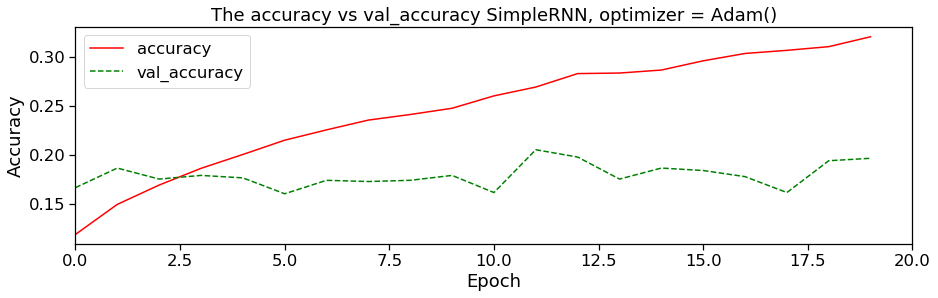

In [23]:
#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history1.history['accuracy'],'r', label='accuracy')
plt.plot(history1.history['val_accuracy'],'g--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, 20])
plt.title('The accuracy vs val_accuracy SimpleRNN, optimizer = Adam()')
plt.legend(loc='best');

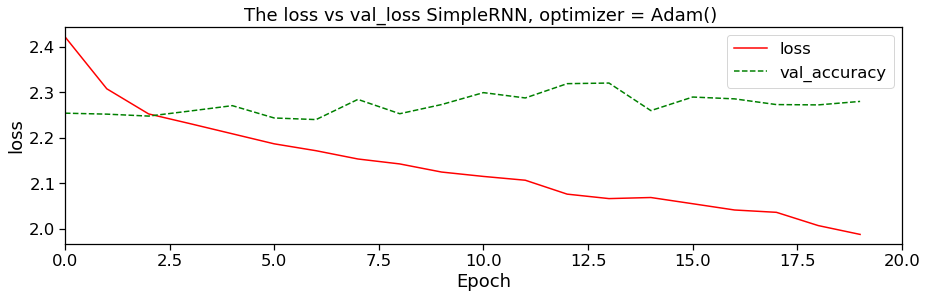

In [24]:
#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history1.history['loss'],'r', label='loss')
plt.plot(history1.history['val_loss'],'g--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.xlim([0, 20])
plt.title('The loss vs val_loss SimpleRNN, optimizer = Adam() ')
plt.legend(loc='best');

As we can see on the plots above, the accuracy with using Adam optimizer also is very low but higher from previouse step: 0.3204 and the val_accuracy with 0.1963 in the point 20 epoch
<br>the val_loss is decreasing with increasing val_accuracy so model isn't overfitted, but it also has a gap between train and test sets scores




 ### Which optimizer gives better results - Adam or RMSprop?

In my humble opinion,  Adam gives better result on the train set, but worse result on the test set

### 4.Explain what is RMSprop optimizer and why is it better or worse for our problem<br>



**sourse links:**
<br>https://ruder.io/optimizing-gradient-descent/index.html#rmsprop
<br>https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a<br>https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b<br>https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/

The `RMSprop` optimizer is similar to the gradient descent algorithm with momentum. The `RMSprop` optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster.

 The central idea of `RMSprop` is keep the moving average of the squared gradients for each weight. And then we divide the gradient by square root the mean square. Which is why it’s called `RMSprop` (root mean square)

We adapt learning rate by dividing by the root of squared gradient, but since we only have the estimate of the gradient on the current mini-batch, wee need instead to use the moving average of it.

RmsProp optimizer has several advantages: 
* for one, it is a very robust optimizer which has pseudo curvature information. 
* Additionally, it can deal with stochastic objectives very nicely, making it applicable to mini batch learning.


*Comparing Adam and RMSprop optimaisers:*

Because of Adam combines methods RSMprop and momentum, its bias-correction helps slightly outperform RMSprop towards the end of optimization as gradients become sparser
<br>But, in our case  RMSprop optimizer is better than Adam optimizer and we able to see it by higher val_accuracy and lower val_loss

### 5.Switch between RNN and LSTM  
**sourse links:**<br>https://en.wikipedia.org/wiki/Long_short-term_memory
 <br> https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714 
 <br>https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0<br>https://medium.com/@purnasaigudikandula/recurrent-neural-networks-and-lstm-explained-7f51c7f6bbb9
<br>https://www.youtube.com/watch?v=WCUNPb-5EYI
<br>https://www.youtube.com/watch?v=SEnXr6v2ifU

For optimizer=RMSprop()

In [25]:
def get_model2():
    d = 0.5
    rd = 0.5
    rnn_units = 128
    input_text = Input((50,))
    text_embedding = Embedding(input_dim=len(word_set) + 2, 
                               output_dim=128,
                               input_length=50, 
                               mask_zero=True)(input_text)
    
    bilstm = LSTM(units=rnn_units, 
                  return_sequences=False, 
                  dropout=d,
                  recurrent_dropout=rd)(text_embedding)
    
    out = Dense(units=10, 
                activation="softmax")(bilstm)
    
    model = Model(input_text, out)
    return model

In [26]:
model2=get_model()
model2.compile(optimizer=RMSprop(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tr_sent2, te_sent2, tr_rel2, te_rel2 = train_test_split(X,
                                                    np.array(Y), 
                                                    test_size=0.1)

history2 = model2.fit(x=tr_sent2, 
                    y=tr_rel2, 
                    validation_data=(te_sent2,te_rel2),
                    batch_size=10, 
                    epochs=20);

Epoch 1/20
720/720 [==============================] - 70s 97ms/step - loss: 2.4410 - accuracy: 0.1164 - val_loss: 2.3076 - val_accuracy: 0.1887
Epoch 2/20
720/720 [==============================] - 69s 95ms/step - loss: 2.3110 - accuracy: 0.1490 - val_loss: 2.2646 - val_accuracy: 0.1787
Epoch 3/20
720/720 [==============================] - 69s 96ms/step - loss: 2.2725 - accuracy: 0.1628 - val_loss: 2.2641 - val_accuracy: 0.1187
Epoch 4/20
720/720 [==============================] - 66s 91ms/step - loss: 2.2502 - accuracy: 0.1674 - val_loss: 2.2217 - val_accuracy: 0.1750
Epoch 5/20
720/720 [==============================] - 45s 63ms/step - loss: 2.2399 - accuracy: 0.1754 - val_loss: 2.2236 - val_accuracy: 0.1737
Epoch 6/20
720/720 [==============================] - 45s 63ms/step - loss: 2.2309 - accuracy: 0.1921 - val_loss: 2.2412 - val_accuracy: 0.1825
Epoch 7/20
720/720 [==============================] - 41s 57ms/step - loss: 2.2230 - accuracy: 0.1919 - val_loss: 2.1868 - val_accuracy:

In [27]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 128)           3416960   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 3,451,146
Trainable params: 3,451,146
Non-trainable params: 0
_________________________________________________________________


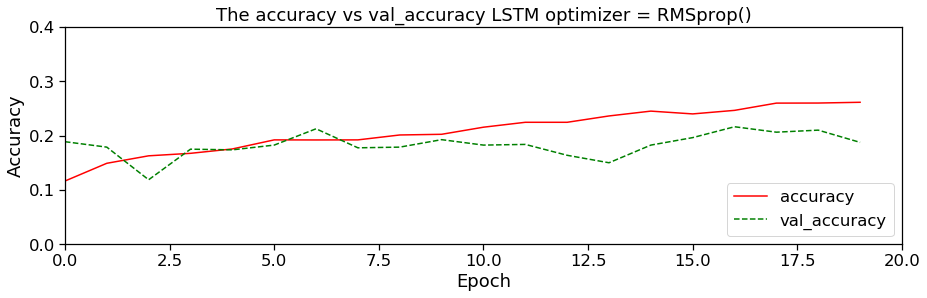

In [28]:
#plot the accuracy 
plt.figure(figsize=(15,4))

plt.plot(history2.history['accuracy'],'r', label='accuracy')
plt.plot(history2.history['val_accuracy'],'g--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.4])
plt.xlim([0, 20])
plt.title('The accuracy vs val_accuracy LSTM optimizer = RMSprop()')
plt.legend(loc='lower right');

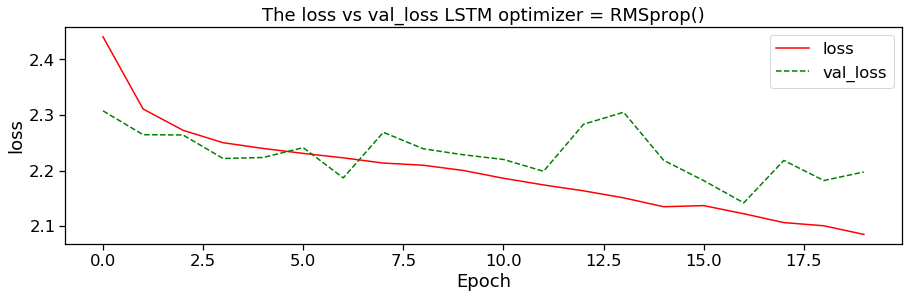

In [29]:
#plot the accuracy loss
plt.figure(figsize=(15,4))
plt.plot(history2.history['loss'],'r', label='loss')
plt.plot(history2.history['val_loss'],'g--', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('The loss vs val_loss LSTM optimizer = RMSprop()')
plt.legend(loc='best');

With  LSTM and RMSprop() optimizer we have better result than it was with SimpleRNN:
    on the 20th epoch we got loss: 2.0851, val_loss: 2.1975,accuracy: 0.2612 and  val_accuracy: 0.1875
<br>this result doesn't outperform the result SimpleRNN with  the same optimizer and the model isn't overfitted


For optimizer=Adam()

In [30]:
model3=get_model()
model3.compile(optimizer=Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tr_sent3, te_sent3, tr_rel3, te_rel3 = train_test_split(X,
                                                    np.array(Y), 
                                                    test_size=0.1)

history3 = model3.fit(x=tr_sent3, 
                    y=tr_rel3, 
                    validation_data=(te_sent3,te_rel3),
                    batch_size=10, 
                    epochs=20);

Epoch 1/20
720/720 [==============================] - 82s 114ms/step - loss: 2.4325 - accuracy: 0.1156 - val_loss: 2.2584 - val_accuracy: 0.1538
Epoch 2/20
720/720 [==============================] - 63s 88ms/step - loss: 2.3046 - accuracy: 0.1517 - val_loss: 2.2793 - val_accuracy: 0.1575
Epoch 3/20
720/720 [==============================] - 68s 94ms/step - loss: 2.2510 - accuracy: 0.1782 - val_loss: 2.2705 - val_accuracy: 0.1688
Epoch 4/20
720/720 [==============================] - 60s 83ms/step - loss: 2.2254 - accuracy: 0.1860 - val_loss: 2.2606 - val_accuracy: 0.1963
Epoch 5/20
720/720 [==============================] - 65s 90ms/step - loss: 2.1997 - accuracy: 0.2006 - val_loss: 2.2459 - val_accuracy: 0.1887
Epoch 6/20
720/720 [==============================] - 66s 92ms/step - loss: 2.1640 - accuracy: 0.2278 - val_loss: 2.2895 - val_accuracy: 0.1412
Epoch 7/20
720/720 [==============================] - 66s 91ms/step - loss: 2.1098 - accuracy: 0.2582 - val_loss: 2.2815 - val_accuracy

In [31]:
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 128)           3416960   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 3,451,146
Trainable params: 3,451,146
Non-trainable params: 0
_________________________________________________________________


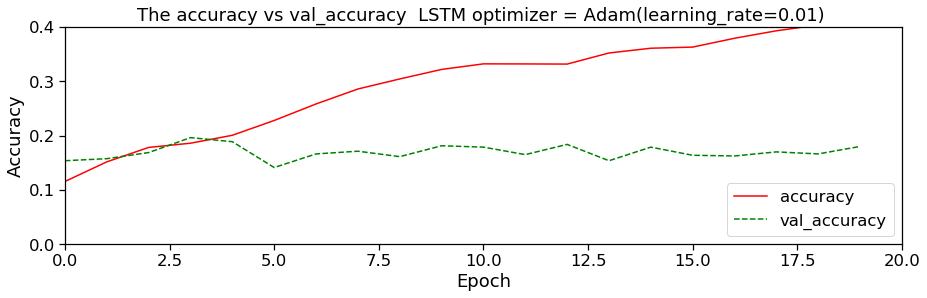

In [32]:
#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history3.history['accuracy'],'r', label='accuracy')
plt.plot(history3.history['val_accuracy'],'g--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.4])
plt.xlim([0, 20])
plt.title('The accuracy vs val_accuracy  LSTM optimizer = Adam(learning_rate=0.01) ')
plt.legend(loc='lower right');

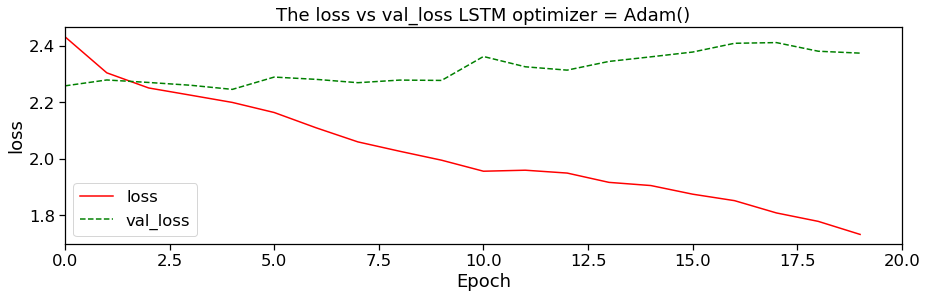

In [33]:
#plot the accuracy loss
plt.figure(figsize=(15,4))
plt.plot(history3.history['loss'],'r', label='loss')
plt.plot(history3.history['val_loss'],'g--', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.xlim([0, 20])
plt.title('The loss vs val_loss LSTM optimizer = Adam()')
plt.legend(loc='best');

We can see, that model LSTM with Adam optimizer is overfitted: the growing val_loss and decreasing loss

### Let's compare the two

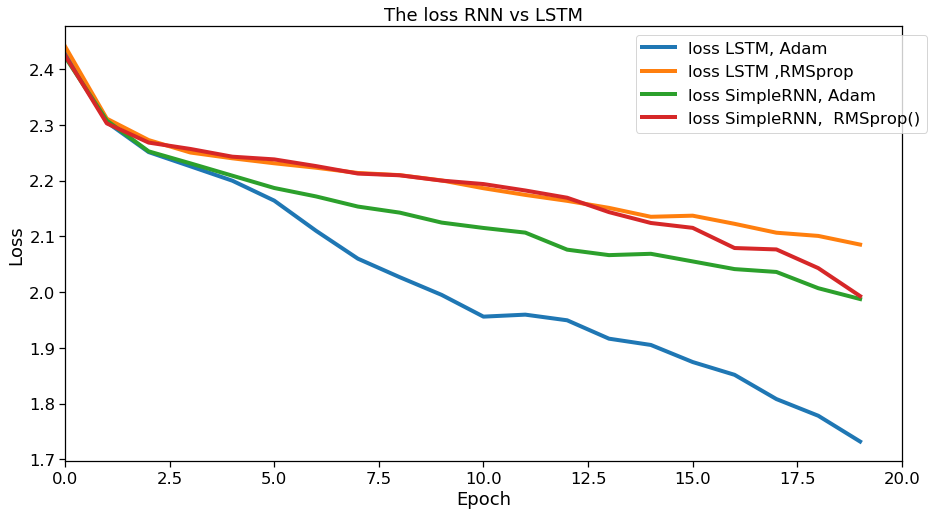

In [34]:
plt.figure(figsize=(15,8))
plt.plot(history3.history['loss'],'-',linewidth=4, label='loss LSTM, Adam ')
plt.plot(history2.history['loss'],'-',linewidth=4, label='loss LSTM ,RMSprop')
plt.plot(history1.history['loss'],'-',linewidth=4, label='loss SimpleRNN, Adam')
plt.plot(history.history['loss'],'-',linewidth=4, label='loss SimpleRNN,  RMSprop()')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0, 20])
plt.title('The loss RNN vs LSTM')
plt.legend(bbox_to_anchor=(1.04, 1));

As we can see on the plot above with loss values on the train set:
    the best result shows SimpleRNN with Adam optimizer and LSTM with Adam optimizer
    
But on the plot below it's clear, that real best result on validation set we got from LSTM  with RMSprop optimizer and SimpleRNN with RMSprop. The rest of models show the growing val_loss values

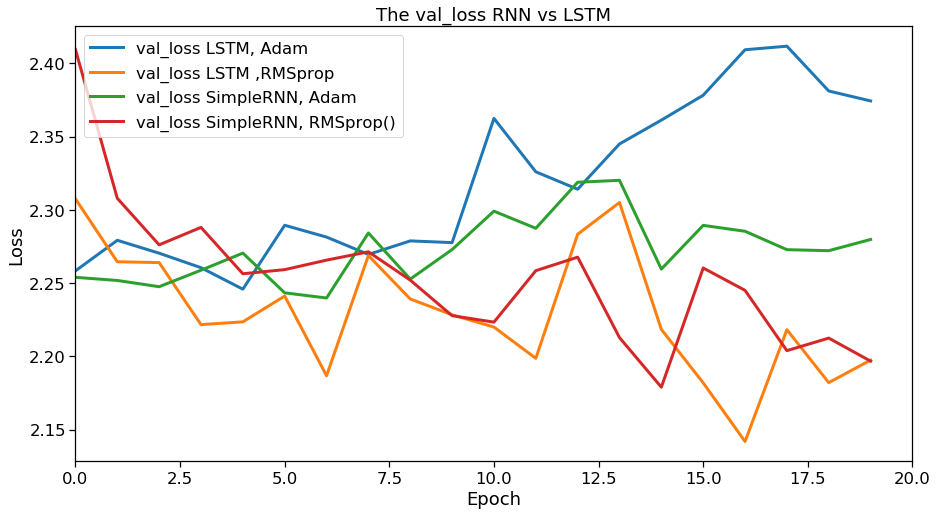

In [35]:
plt.figure(figsize=(15,8))
plt.plot(history3.history['val_loss'],'-' ,linewidth=3,label = 'val_loss LSTM, Adam ')
plt.plot(history2.history['val_loss'],'-',linewidth=3, label = 'val_loss LSTM ,RMSprop')
plt.plot(history1.history['val_loss'],'-',linewidth=3, label = 'val_loss SimpleRNN, Adam')
plt.plot(history.history['val_loss'],'-',linewidth=3, label = 'val_loss SimpleRNN, RMSprop()')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0, 20])
plt.title('The val_loss RNN vs LSTM')
plt.legend(loc='best');